#Run to download the data set

In [ ]:
!pip install opendatasets

In [ ]:

import opendatasets as od
od.download("https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: belindatsai
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews


100%|██████████| 657M/657M [00:01<00:00, 367MB/s]


## webscraping from google maps using google maps API  

you need a google maps API key

In [ ]:
import requests
import csv
import time
import random

# ------------------------------------------------------
# 1️⃣ Read Google Maps API key from a local file
# ------------------------------------------------------
with open("apikey.txt", "r") as f:
    GOOGLE_MAPS_API_KEY = f.read().strip()

# ------------------------------------------------------
# 2️⃣ Configuration
# ------------------------------------------------------
CITIES = ["Washington, DC, USA", "London, UK", "Singapore", "Beijing, China"]
SEARCH_QUERY = "restaurant"
DELAY_BETWEEN_REQUESTS = 1       # seconds
MAX_REVIEWS_PER_PLACE = 5        # limit reviews per business
MAX_PLACES = 50                  # total businesses to fetch per city

# ------------------------------------------------------
# 2️⃣b Optional: Promo text injection for testing
# ------------------------------------------------------
INJECT_PROMO_TEST = True  # Toggle off before submission
PROMO_PHRASES = [
    "Visit www.bestfoodpromo.com for 10% off this week!",
    "Call now and get a free dessert!",
    "Check our menu online and follow us for deals!"
]

# ------------------------------------------------------
# 2️⃣c API request limits to avoid accidental billing
# ------------------------------------------------------
MAX_TOTAL_REQUESTS = 100
requests_made = 0

# ------------------------------------------------------
# 3️⃣ Helper: Search for restaurants in a city
# ------------------------------------------------------
def search_places(query, city, max_places=MAX_PLACES):
    global requests_made
    url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
    places = []
    params = {
        "query": f"{query} in {city}",
        "type": "restaurant",
        "key": GOOGLE_MAPS_API_KEY
    }

    while url and len(places) < max_places:
        if requests_made >= MAX_TOTAL_REQUESTS:
            print("Reached maximum allowed requests, stopping early to avoid billing.")
            break

        response = requests.get(url, params=params)
        requests_made += 1

        data = response.json()
        results = data.get("results", [])
        places.extend(results)

        if "next_page_token" in data and len(places) < max_places:
            time.sleep(2)  # wait for token to become active
            url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
            params = {
                "pagetoken": data["next_page_token"],
                "key": GOOGLE_MAPS_API_KEY
            }
        else:
            break
    return places[:max_places]

# ------------------------------------------------------
# 4️⃣ Helper: Get reviews for a place
# ------------------------------------------------------
def get_place_reviews(place_id, max_reviews=MAX_REVIEWS_PER_PLACE):
    global requests_made
    if requests_made >= MAX_TOTAL_REQUESTS:
        return []

    url = "https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        "place_id": place_id,
        "fields": "name,reviews",
        "key": GOOGLE_MAPS_API_KEY
    }
    response = requests.get(url, params=params)
    requests_made += 1

    if response.status_code != 200:
        return []
    data = response.json()
    reviews = data.get("result", {}).get("reviews", [])
    return reviews[:max_reviews]

# ------------------------------------------------------
# 5️⃣ Scrape and write CSV
# ------------------------------------------------------
with open("scraped_reviews.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["business_name", "author_name", "text", "photo"])
    writer.writeheader()

    total_places_scraped = 0
    for city in CITIES:
        places = search_places(SEARCH_QUERY, city, max_places=MAX_PLACES)

        for place in places:
            place_id = place.get("place_id")
            business_name = place.get("name")
            if not place_id:
                continue

            reviews = get_place_reviews(place_id)
            for review in reviews:
                review_text = review.get("text", "")

                # Inject promo text if enabled
                if INJECT_PROMO_TEST and random.random() < 0.05:  # 5% of reviews
                    review_text += " " + random.choice(PROMO_PHRASES)

                writer.writerow({
                    "business_name": business_name,
                    "author_name": review.get("author_name", "Unknown"),
                    "text": review_text,
                    "photo": ""  # placeholder
                })

            print(f"Scraped {len(reviews)} reviews for {business_name} in {city}")
            total_places_scraped += 1
            time.sleep(DELAY_BETWEEN_REQUESTS)

print(f"Total businesses scraped across all cities: {total_places_scraped}")
print(f"Total API requests made: {requests_made}")


FileNotFoundError: [Errno 2] No such file or directory: 'apikey.txt'

#Data Ingestion and Data Processing

In [ ]:
# Install dependencies
!pip install pandas scikit-learn nltk

import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
nltk.download('punkt')

# --- 1. Load CSVs ---
reviews_df = pd.read_csv("/content/google-maps-restaurant-reviews/reviews.csv")
meta_df = pd.read_csv("/content/google-maps-restaurant-reviews/sepetcioglu_restaurant.csv")

print("=== Reviews CSV (first 5 rows) ===")
print(reviews_df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


=== Reviews CSV (first 5 rows) ===
                     business_name    author_name  \
0  Haci'nin Yeri - Yigit Lokantasi    Gulsum Akar   
1  Haci'nin Yeri - Yigit Lokantasi  Oguzhan Cetin   
2  Haci'nin Yeri - Yigit Lokantasi     Yasin Kuyu   
3  Haci'nin Yeri - Yigit Lokantasi     Orhan Kapu   
4  Haci'nin Yeri - Yigit Lokantasi     Ozgur Sati   

                                                text  \
0  We went to Marmaris with my wife for a holiday...   
1  During my holiday in Marmaris we ate here to f...   
2  Prices are very affordable. The menu in the ph...   
3  Turkey's cheapest artisan restaurant and its f...   
4  I don't know what you will look for in terms o...   

                                               photo  rating  \
0         dataset/taste/hacinin_yeri_gulsum_akar.png       5   
1        dataset/menu/hacinin_yeri_oguzhan_cetin.png       4   
2  dataset/outdoor_atmosphere/hacinin_yeri_yasin_...       3   
3  dataset/indoor_atmosphere/hacinin_yeri_orhan_k... 

In [ ]:
print("\n=== Restaurant Metadata CSV (first 5 rows) ===")
print(meta_df.head())


=== Restaurant Metadata CSV (first 5 rows) ===
                           photo  rating    rating_category
0  sepetcioglu_restaurant/09.png       4              taste
1  sepetcioglu_restaurant/01.png       5  indoor_atmosphere
2  sepetcioglu_restaurant/25.png       2               menu
3  sepetcioglu_restaurant/10.png       5              taste
4  sepetcioglu_restaurant/02.png       3  indoor_atmosphere


In [ ]:
import pandas as pd
import re

reviews1 = reviews_df
reviews2 = pd.read_csv("scraped_reviews.csv")

all_reviews = pd.concat([reviews1, reviews2], ignore_index=True)



FileNotFoundError: [Errno 2] No such file or directory: 'scraped_reviews.csv'

In [ ]:
def clean_text_for_transformers(text):
    """Clean text but preserve useful signals for transformers."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "URL", text)   # replace links with token
    text = re.sub(r"[^a-zA-Z\s]", " ", text)       # keep letters + spaces
    text = re.sub(r"\s+", " ", text).strip()       # normalize whitespace
    return text



In [ ]:
# ------------------------------------------------------
# 4️⃣ Apply cleaning
# ------------------------------------------------------
all_reviews['cleaned_review'] = all_reviews['text'].apply(clean_text_for_transformers)
# ------------------------------------------------------
# 5️⃣ Save to a single CSV
# ------------------------------------------------------
all_reviews.to_csv("reviews_clean.csv", index=False, encoding="utf-8")

print("Combined and cleaned dataset saved as reviews_clean.csv")
# Preview first 10 cleaned reviews
print(all_reviews[['text', 'cleaned_review']].head(10))


NameError: name 'all_reviews' is not defined

# EDA for cleaned Data set


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00
Dataset Shape: (1570, 7)

Column Names and Data Types:
business_name       object
author_name         object
text                object
photo               object
rating             float64
rating_category     object
cleaned_review      object
dtype: object

First 5 rows:
                     business_name    author_name  \
0  Haci'nin Yeri - Yigit Lokantasi    Gulsum Akar   
1  Haci'nin Yeri - Yigit Lokantasi  Oguzhan Cetin   
2  Haci'nin Yeri - Yigit Lokantasi     Yasin Kuyu   
3  Haci'nin Yeri - Yigit Lokantasi     Orhan Kapu   
4  Haci'nin Yeri - Yigit Lokantasi     Ozgur Sati   

                                                text  \
0  We went to Marmaris with my wife for a holiday...   
1  During my holiday in Marmaris we ate here to f...   
2  Prices are very affordable. The menu in the ph...   
3  Turkey's cheapest artisan restaurant and its f...   
4  I don't know what you will look for in terms 

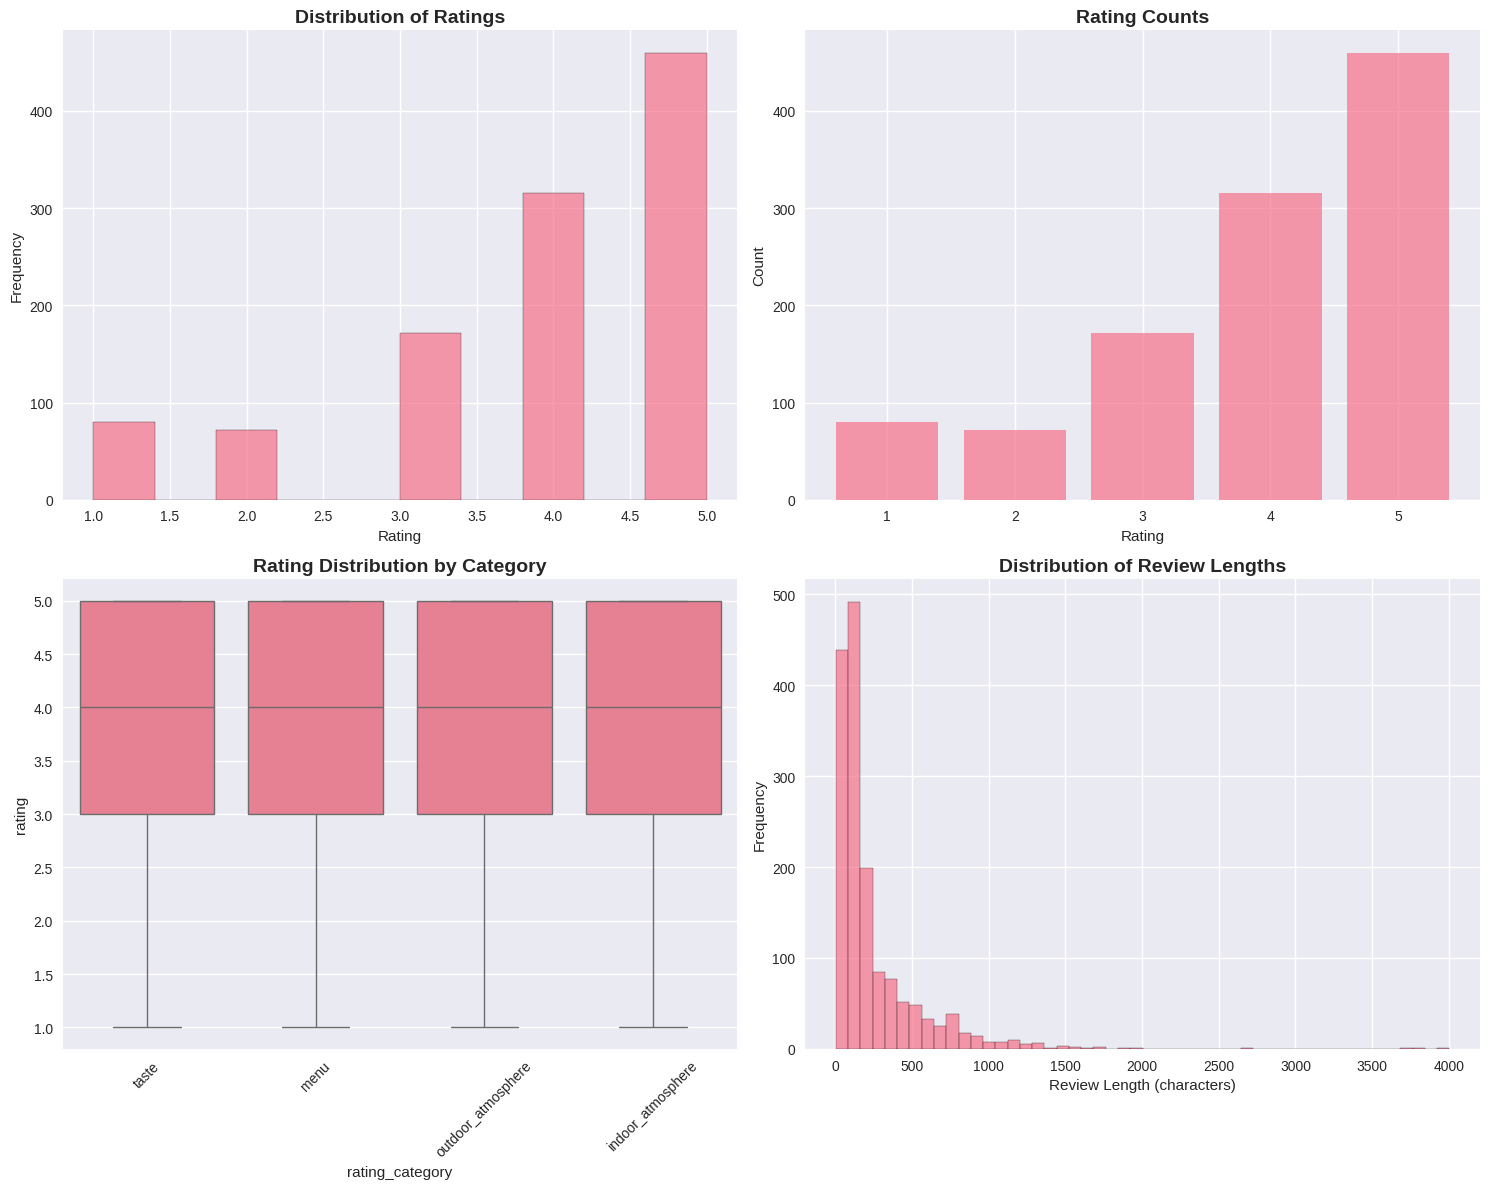

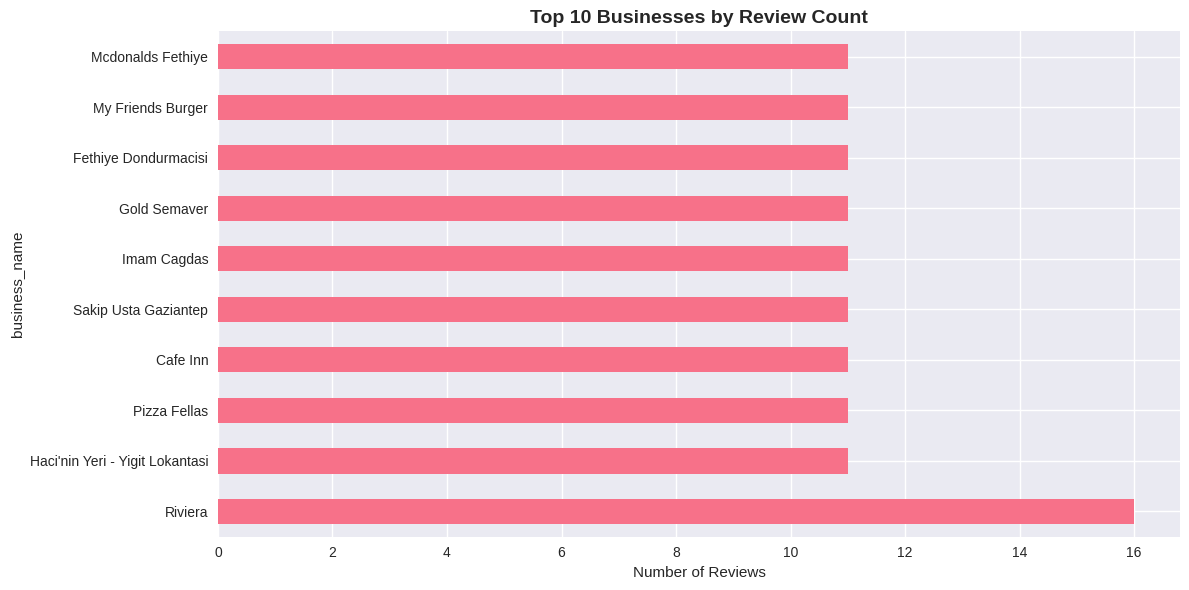

Top 10 Businesses by Average Rating (min 5 reviews):
                                 review_count  avg_rating  rating_std  \
business_name                                                           
Pizzeria Remo                              11        4.55        0.69   
Haci'nin Yeri - Yigit Lokantasi            11        4.45        0.82   
Churchill Bistro                           11        4.45        0.93   
Bunbun Kas                                 11        4.45        0.69   
Yesemek                                    11        4.45        1.21   
Antakya Mutfagi                            11        4.45        0.69   
Cici Tantuni                               11        4.36        0.67   
Hasan Usta                                 11        4.36        0.81   
Suflor                                     11        4.36        0.81   
Kumsal Lokantasi                           11        4.36        0.67   

                                 avg_review_length  
business_name    

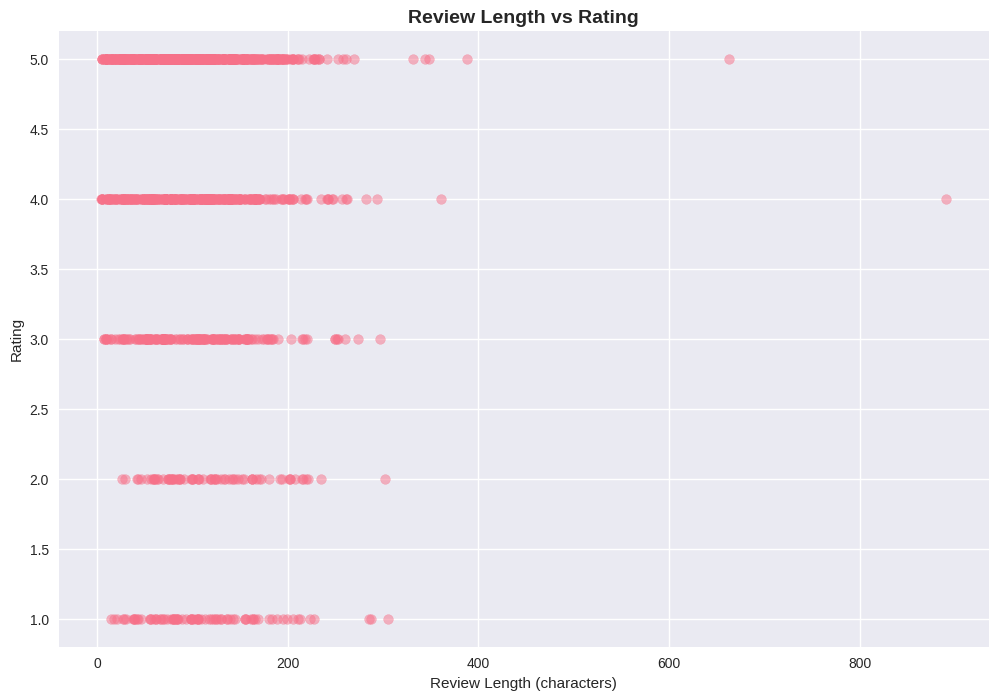

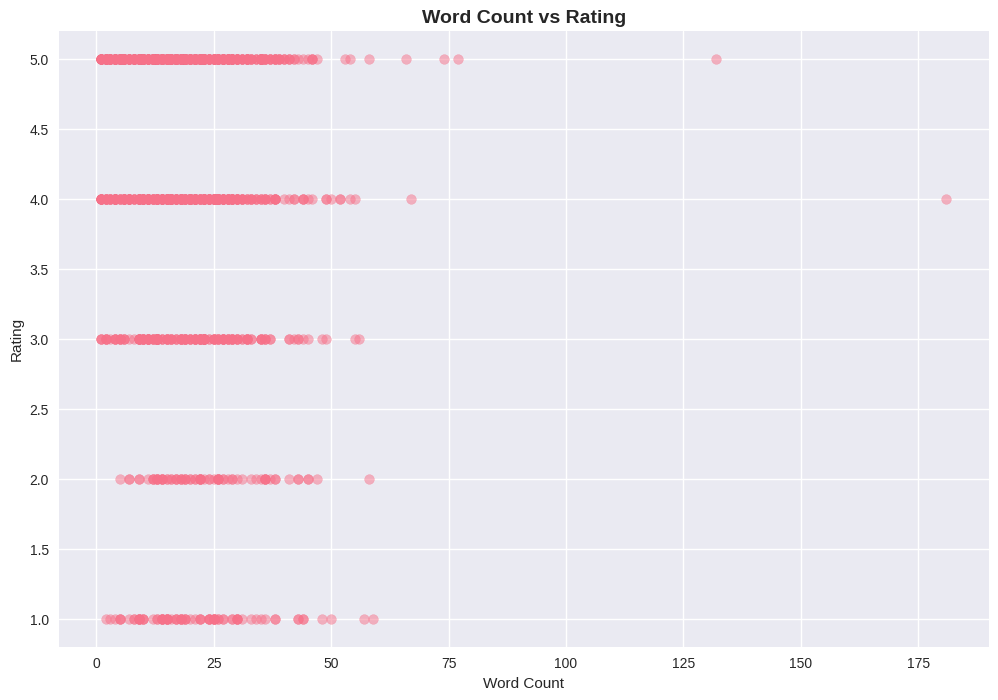

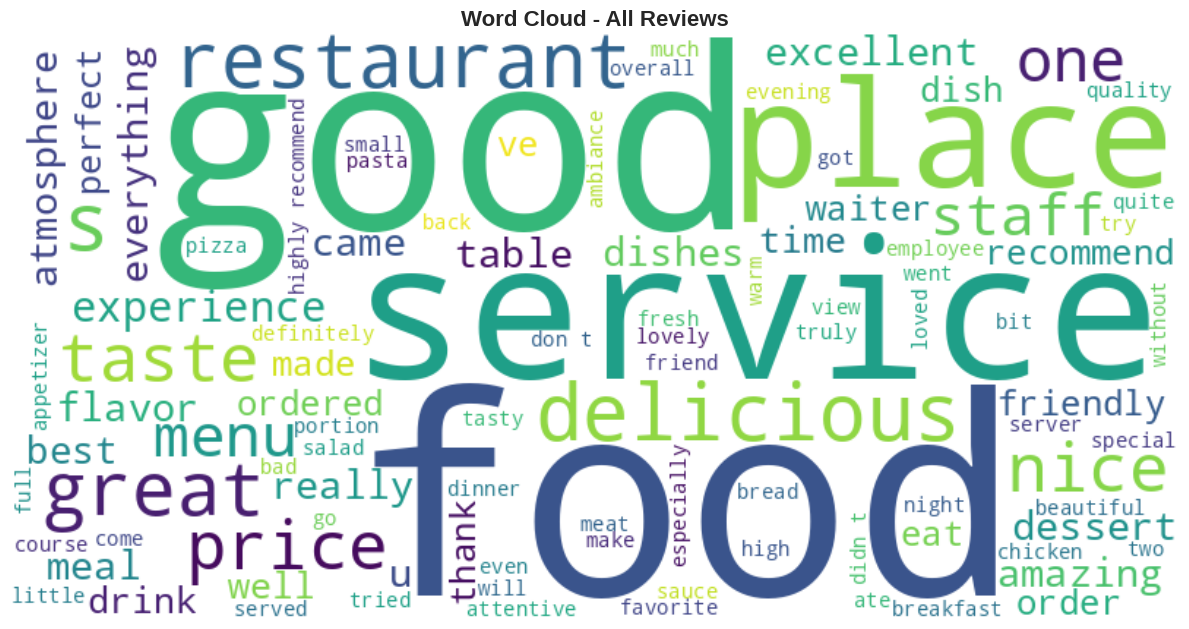

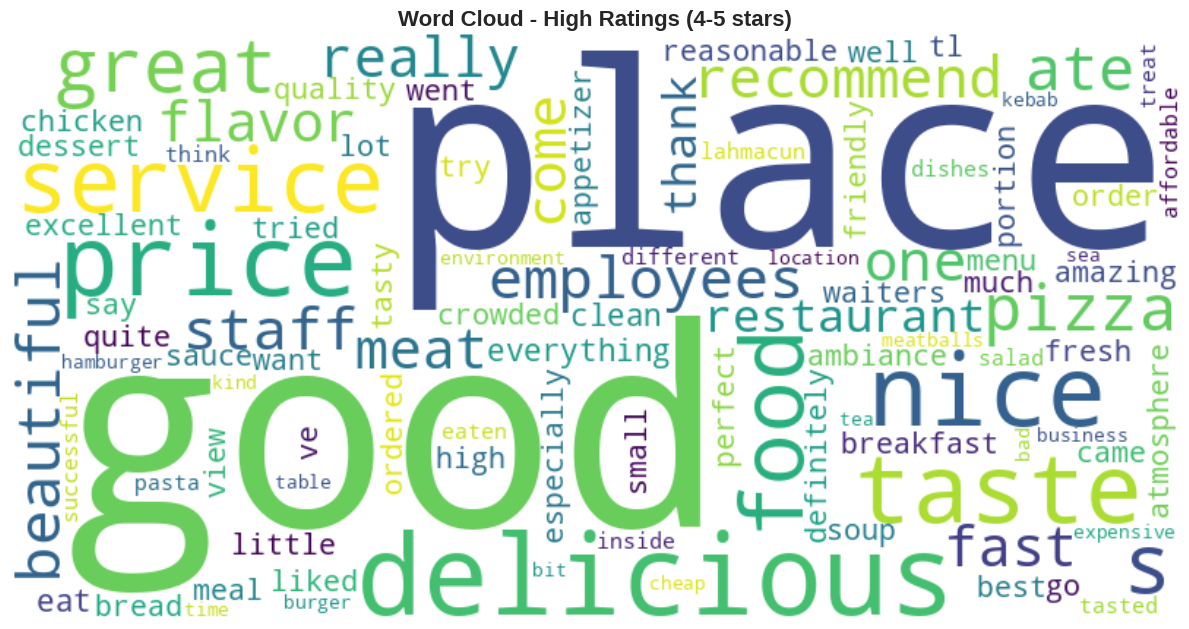

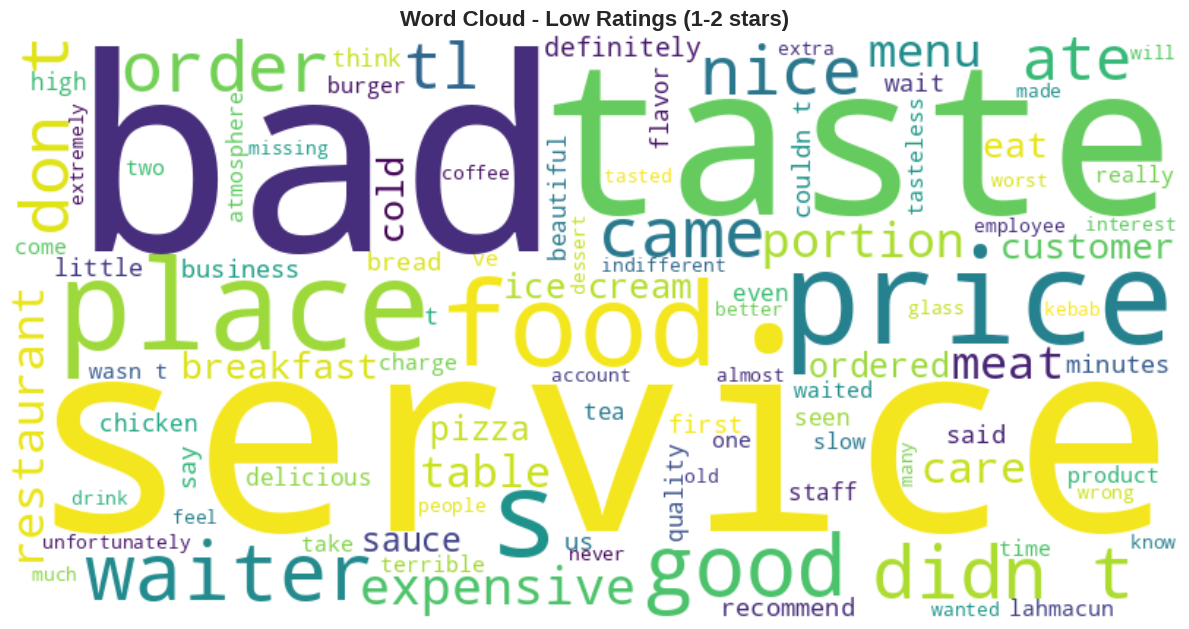

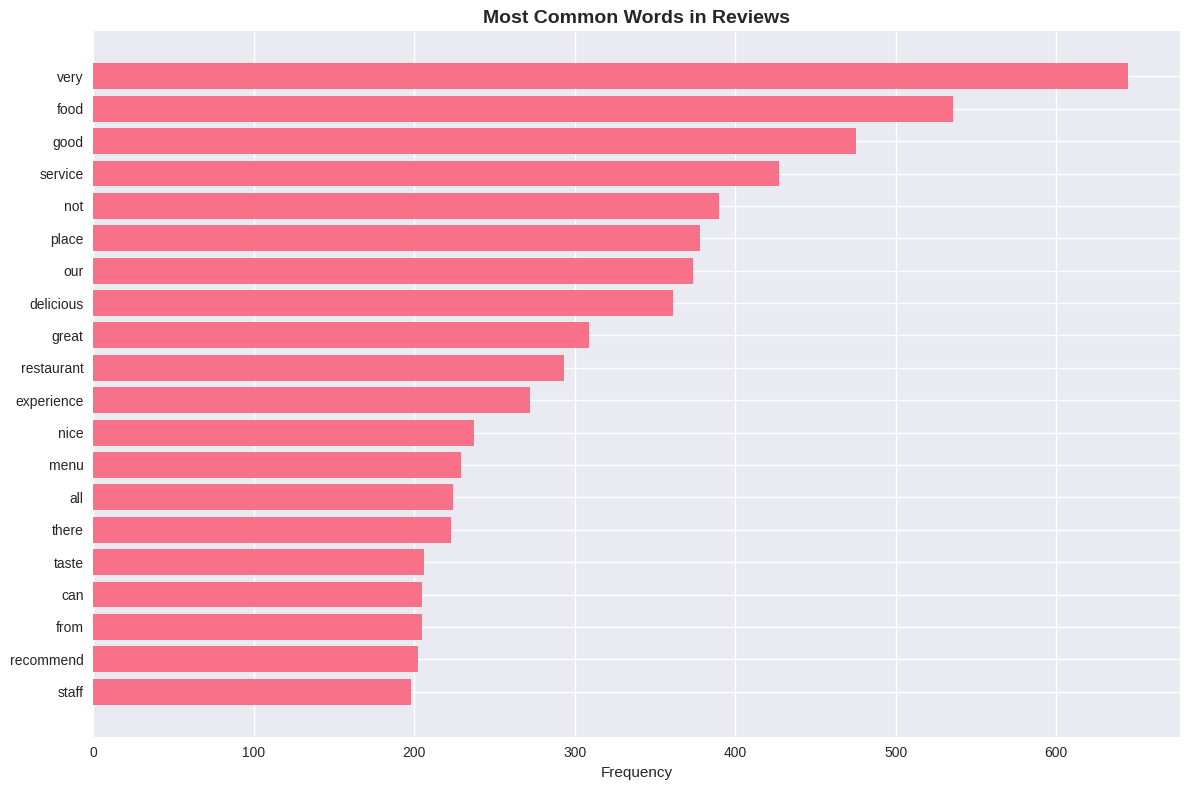

Performing sentiment analysis...


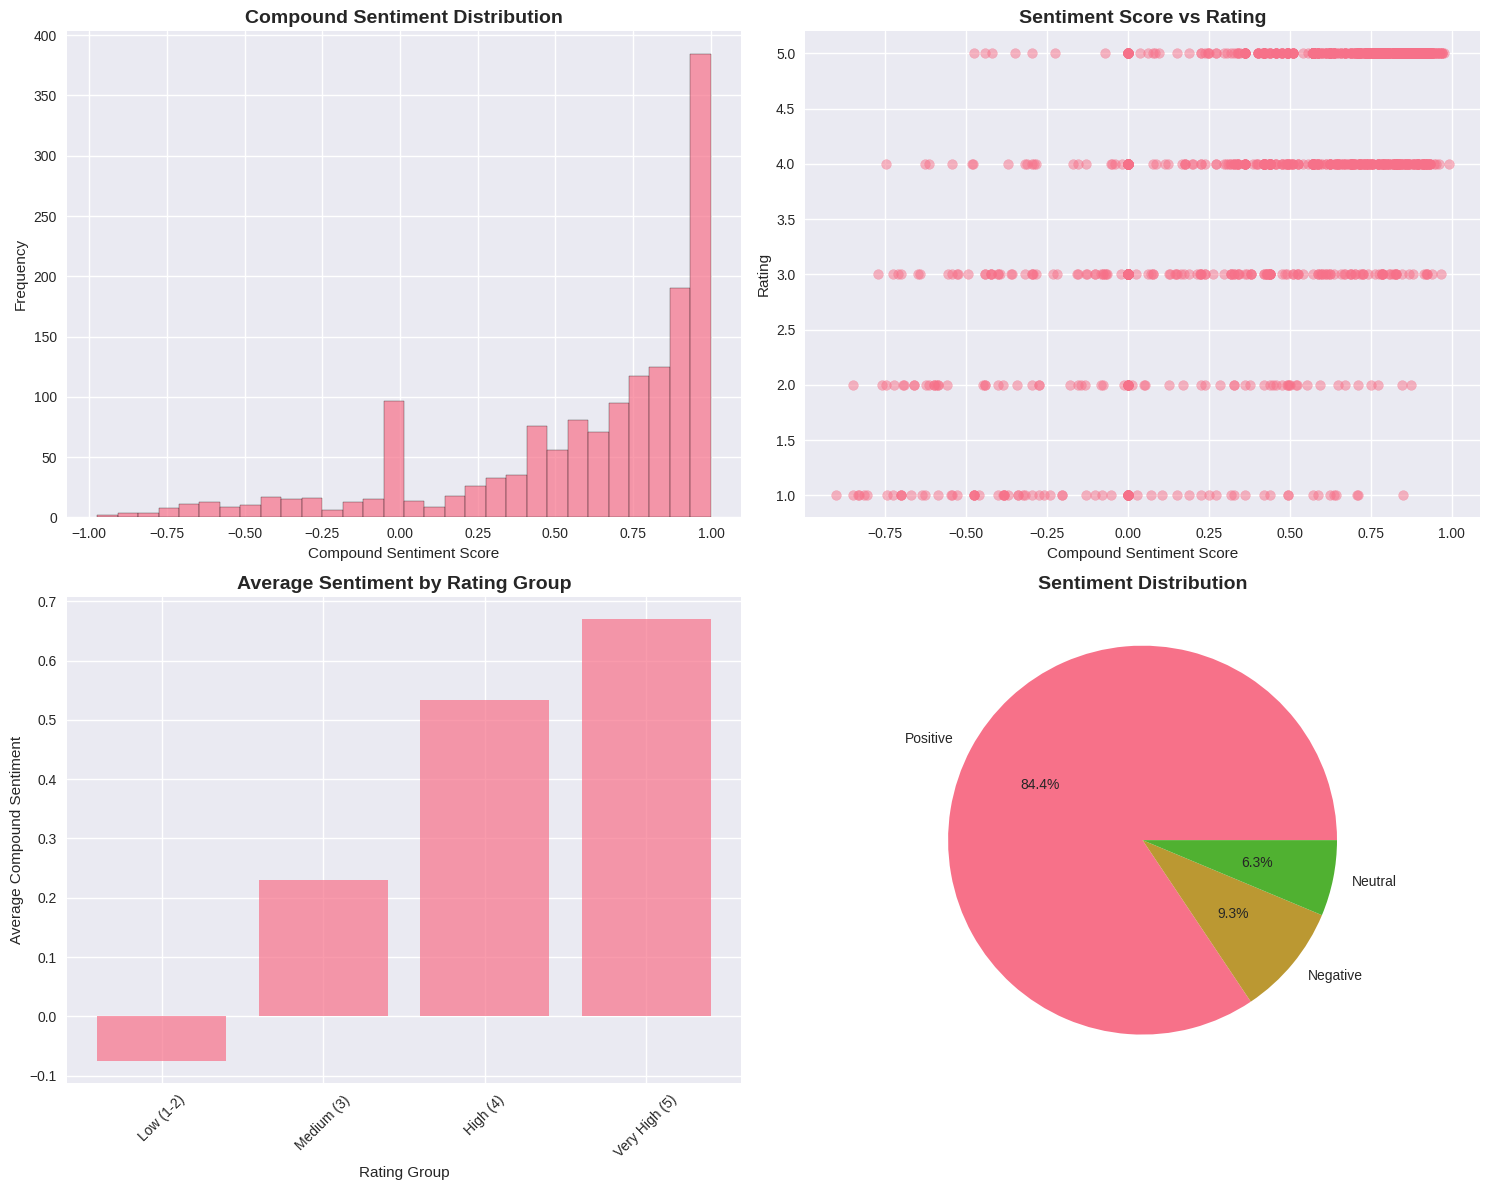

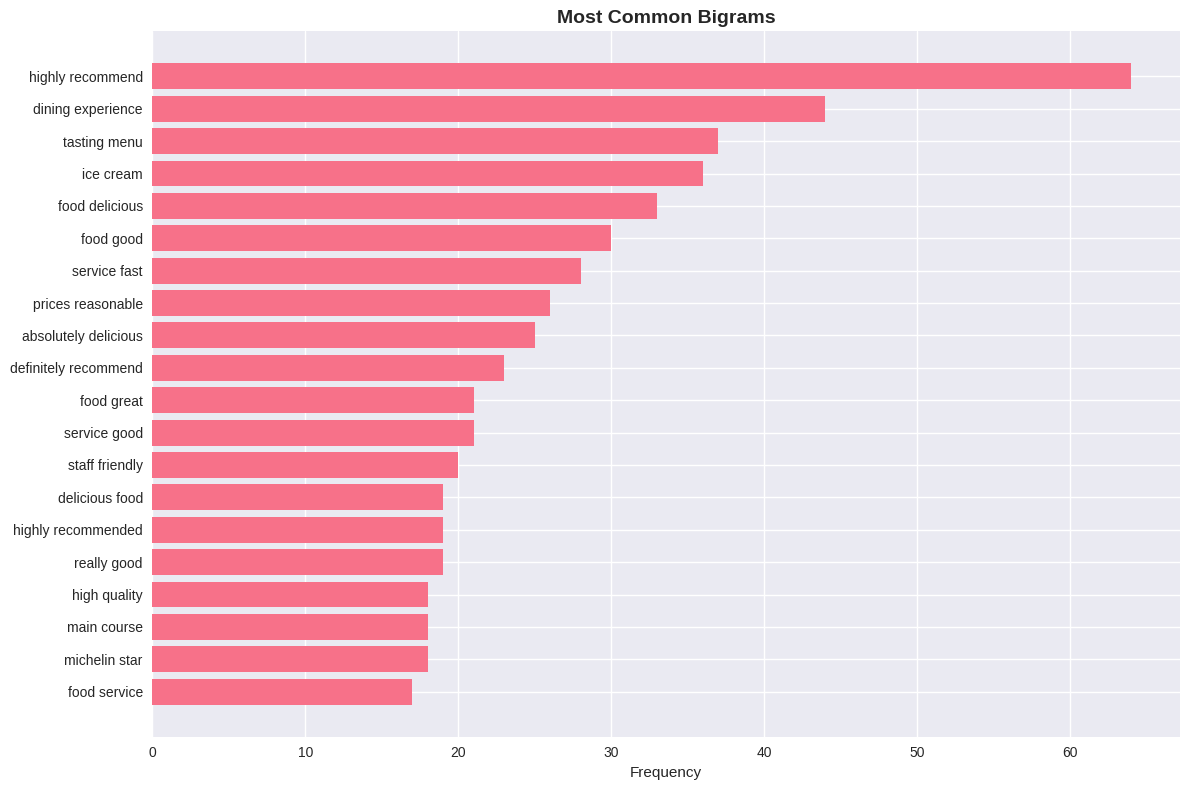

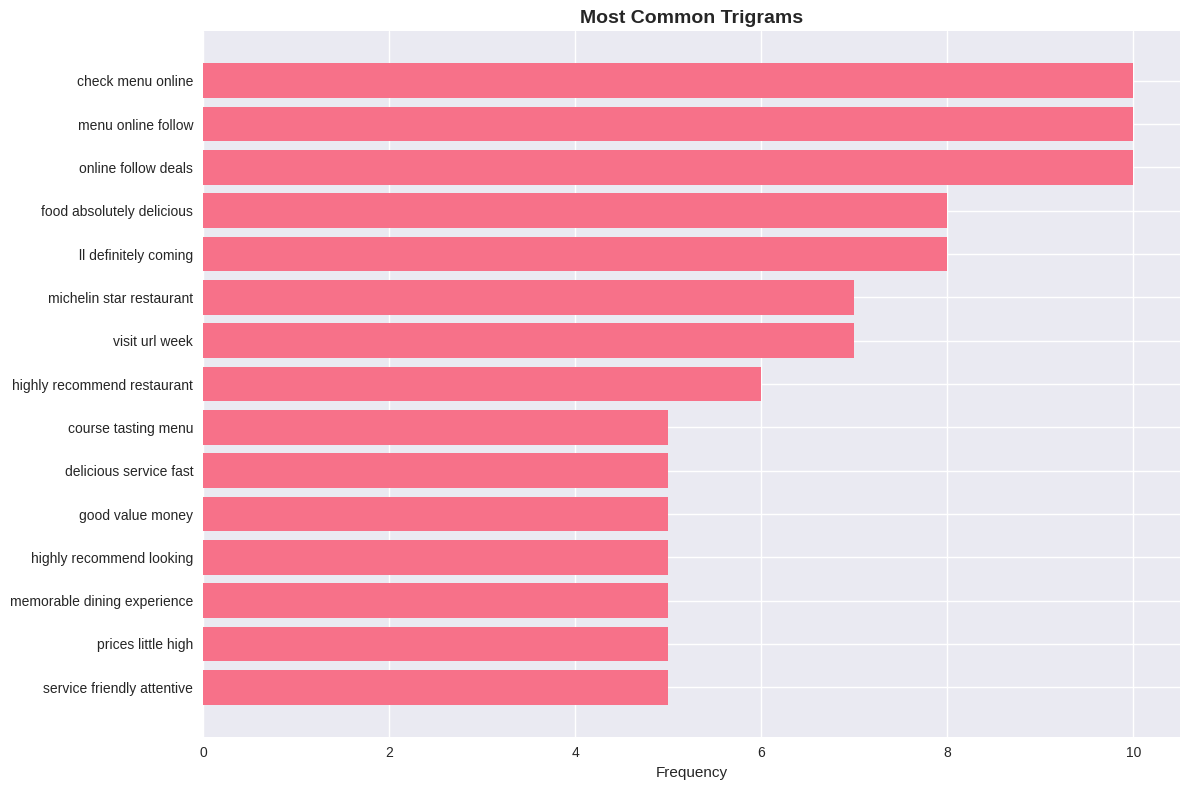

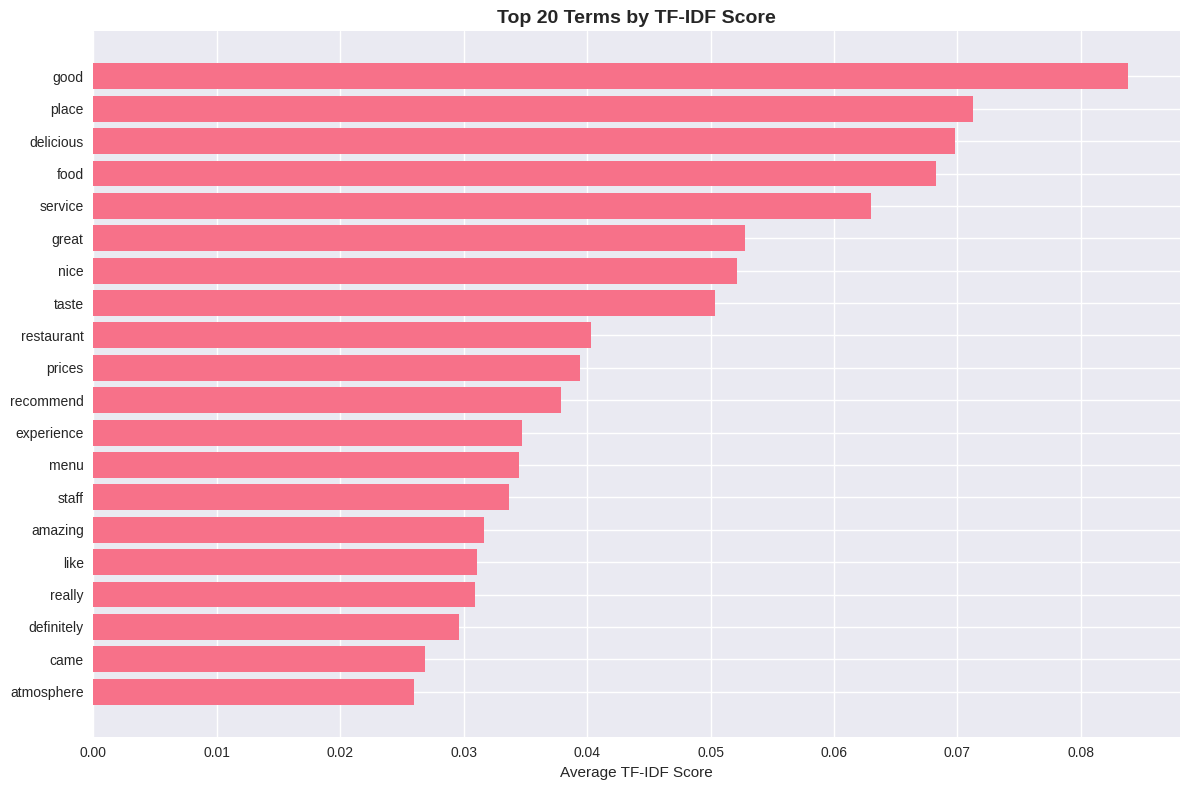

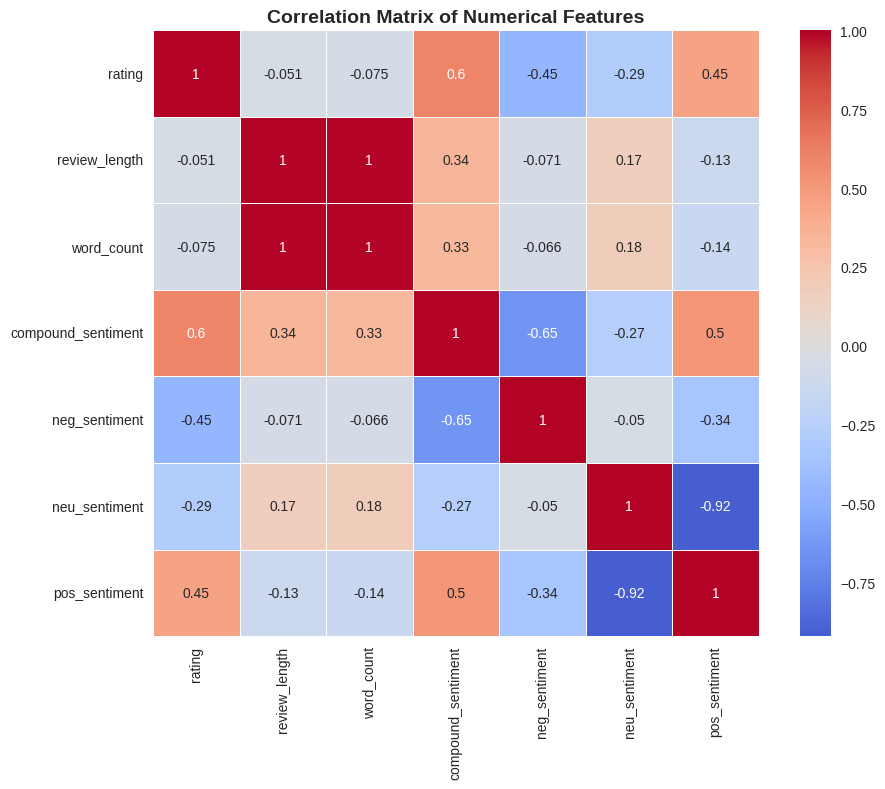

Summary Statistics by Rating Category:
                        review_length        word_count         \
                                 mean    std       mean    std   
rating_category_derived                                          
Poor                           117.24  61.13      22.78  11.91   
Fair                           105.30  59.79      20.29  11.31   
Good                           106.80  74.58      20.28  14.63   
Excellent                      104.33  66.49      19.35  12.99   

                        compound_sentiment       rating  
                                      mean   std  count  
rating_category_derived                                  
Poor                                 -0.08  0.46    152  
Fair                                  0.23  0.43    172  
Good                                  0.53  0.34    316  
Excellent                             0.67  0.26    460  

ANALYSIS SUMMARY
Total Reviews Analyzed: 1570
Average Rating: 3.91
Average Review Length: 2

In [ ]:
# Reviews Dataset NLP & EDA Analysis

## 1. Install Required Packages and Import Libraries

# Install required packages
!pip install wordcloud textblob vaderSentiment plotly

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
from wordcloud import WordCloud
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set figure size defaults
plt.rcParams['figure.figsize'] = [12, 8]

## 2. Load and Initial Data Exploration

# Load the dataset
df = pd.read_csv('reviews_clean.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe(include='all'))

## 3. Data Preprocessing and Cleaning

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Remove duplicates if any
df = df.drop_duplicates()

# Convert rating to numeric if it's not already
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Create additional features
df['review_length'] = df['cleaned_review'].str.len()
df['word_count'] = df['cleaned_review'].str.split().str.len()

# Display updated info
print(f"Final dataset shape: {df.shape}")

## 4. Exploratory Data Analysis (EDA)

### 4.1 Rating Distribution Analysis

# Rating distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Rating distribution histogram
axes[0,0].hist(df['rating'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frequency')

# Rating counts
rating_counts = df['rating'].value_counts().sort_index()
axes[0,1].bar(rating_counts.index, rating_counts.values, alpha=0.7)
axes[0,1].set_title('Rating Counts', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('Count')

# Box plot of ratings by category (if available)
if 'rating_category' in df.columns:
    sns.boxplot(data=df, x='rating_category', y='rating', ax=axes[1,0])
    axes[1,0].set_title('Rating Distribution by Category', fontsize=14, fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45)

# Review length distribution
axes[1,1].hist(df['review_length'], bins=50, edgecolor='black', alpha=0.7)
axes[1,1].set_title('Distribution of Review Lengths', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Review Length (characters)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 4.2 Business Analysis

# Top businesses by review count
top_businesses = df['business_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_businesses.plot(kind='barh')
plt.title('Top 10 Businesses by Review Count', fontsize=14, fontweight='bold')
plt.xlabel('Number of Reviews')
plt.tight_layout()
plt.show()

# Average rating by business (for businesses with >5 reviews)
business_stats = df.groupby('business_name').agg({
    'rating': ['count', 'mean', 'std'],
    'review_length': 'mean'
}).round(2)

business_stats.columns = ['review_count', 'avg_rating', 'rating_std', 'avg_review_length']
business_stats = business_stats[business_stats['review_count'] > 5].sort_values('avg_rating', ascending=False)

print("Top 10 Businesses by Average Rating (min 5 reviews):")
print(business_stats.head(10))

### 4.3 Text Length Analysis

# Relationship between review length and rating
plt.figure(figsize=(12, 8))
plt.scatter(df['review_length'], df['rating'], alpha=0.5)
plt.xlabel('Review Length (characters)')
plt.ylabel('Rating')
plt.title('Review Length vs Rating', fontsize=14, fontweight='bold')
plt.show()

# Word count vs rating
plt.figure(figsize=(12, 8))
plt.scatter(df['word_count'], df['rating'], alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Rating')
plt.title('Word Count vs Rating', fontsize=14, fontweight='bold')
plt.show()

## 5. Natural Language Processing Analysis

### 5.1 Word Cloud Generation

# Function to create word cloud
def create_wordcloud(text, title, max_words=100):
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=max_words,
                         colormap='viridis').generate(text)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Overall word cloud
all_text = ' '.join(df['cleaned_review'].dropna().astype(str))
create_wordcloud(all_text, 'Word Cloud - All Reviews')

# Word cloud by rating categories
high_rating_text = ' '.join(df[df['rating'] >= 4]['cleaned_review'].dropna().astype(str))
create_wordcloud(high_rating_text, 'Word Cloud - High Ratings (4-5 stars)')

low_rating_text = ' '.join(df[df['rating'] <= 2]['cleaned_review'].dropna().astype(str))
create_wordcloud(low_rating_text, 'Word Cloud - Low Ratings (1-2 stars)')

### 5.2 Most Common Words Analysis

# Function to get most common words
def get_common_words(text_series, n_words=20):
    # Combine all text
    text = ' '.join(text_series.dropna().astype(str))

    # Simple word extraction (you might want to add more sophisticated preprocessing)
    words = re.findall(r'\b\w+\b', text.lower())

    # Remove common stop words (basic list)
    stop_words = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
                  'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had',
                  'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they'}

    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    return Counter(filtered_words).most_common(n_words)

# Most common words overall
common_words = get_common_words(df['cleaned_review'])
words, counts = zip(*common_words)

plt.figure(figsize=(12, 8))
plt.barh(range(len(words)), counts)
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Most Common Words in Reviews', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 5.3 Sentiment Analysis

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    try:
        scores = analyzer.polarity_scores(str(text))
        return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])
    except:
        return pd.Series([0, 0, 0, 0])

# Apply sentiment analysis
print("Performing sentiment analysis...")
df[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']] = \
    df['cleaned_review'].apply(get_sentiment_scores)

# Sentiment distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Compound sentiment distribution
axes[0,0].hist(df['compound_sentiment'], bins=30, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Compound Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Compound Sentiment Score')
axes[0,0].set_ylabel('Frequency')

# Sentiment vs Rating
axes[0,1].scatter(df['compound_sentiment'], df['rating'], alpha=0.5)
axes[0,1].set_title('Sentiment Score vs Rating', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Compound Sentiment Score')
axes[0,1].set_ylabel('Rating')

# Sentiment by rating groups
df['rating_group'] = pd.cut(df['rating'], bins=[0, 2, 3, 4, 5], labels=['Low (1-2)', 'Medium (3)', 'High (4)', 'Very High (5)'])
sentiment_by_rating = df.groupby('rating_group')['compound_sentiment'].mean()
axes[1,0].bar(sentiment_by_rating.index, sentiment_by_rating.values, alpha=0.7)
axes[1,0].set_title('Average Sentiment by Rating Group', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Rating Group')
axes[1,0].set_ylabel('Average Compound Sentiment')
axes[1,0].tick_params(axis='x', rotation=45)

# Distribution of sentiment categories
sentiment_labels = []
for score in df['compound_sentiment']:
    if score >= 0.05:
        sentiment_labels.append('Positive')
    elif score <= -0.05:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

df['sentiment_label'] = sentiment_labels
sentiment_counts = df['sentiment_label'].value_counts()
axes[1,1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 5.4 N-gram Analysis

# Function for n-gram analysis
def get_ngrams(text_series, n=2, top_n=20):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=1000, stop_words='english')
    try:
        X = vectorizer.fit_transform(text_series.dropna().astype(str))
        ngrams = vectorizer.get_feature_names_out()
        counts = X.sum(axis=0).A1
        ngram_counts = list(zip(ngrams, counts))
        return sorted(ngram_counts, key=lambda x: x[1], reverse=True)[:top_n]
    except:
        return []

# Bigram analysis
bigrams = get_ngrams(df['cleaned_review'], n=2, top_n=20)
if bigrams:
    bigram_words, bigram_counts = zip(*bigrams)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(bigram_words)), bigram_counts)
    plt.yticks(range(len(bigram_words)), bigram_words)
    plt.xlabel('Frequency')
    plt.title('Most Common Bigrams', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Trigram analysis
trigrams = get_ngrams(df['cleaned_review'], n=3, top_n=15)
if trigrams:
    trigram_words, trigram_counts = zip(*trigrams)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(trigram_words)), trigram_counts)
    plt.yticks(range(len(trigram_words)), trigram_words)
    plt.xlabel('Frequency')
    plt.title('Most Common Trigrams', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### 5.5 TF-IDF Analysis

# TF-IDF for important terms
tfidf = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2))
try:
    tfidf_matrix = tfidf.fit_transform(df['cleaned_review'].dropna().astype(str))
    feature_names = tfidf.get_feature_names_out()

    # Get average TF-IDF scores
    mean_scores = tfidf_matrix.mean(axis=0).A1
    tfidf_scores = list(zip(feature_names, mean_scores))
    tfidf_scores.sort(key=lambda x: x[1], reverse=True)

    # Plot top TF-IDF terms
    top_tfidf = tfidf_scores[:20]
    terms, scores = zip(*top_tfidf)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(terms)), scores)
    plt.yticks(range(len(terms)), terms)
    plt.xlabel('Average TF-IDF Score')
    plt.title('Top 20 Terms by TF-IDF Score', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"TF-IDF analysis error: {e}")

## 6. Advanced Analysis

### 6.1 Correlation Analysis

# Correlation matrix of numerical features
numerical_cols = ['rating', 'review_length', 'word_count', 'compound_sentiment',
                  'neg_sentiment', 'neu_sentiment', 'pos_sentiment']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.2 Rating Prediction based on Text Features

# Create rating categories for analysis
df['rating_category_derived'] = pd.cut(df['rating'],
                                     bins=[0, 2, 3, 4, 5],
                                     labels=['Poor', 'Fair', 'Good', 'Excellent'])

# Summary statistics by rating category
summary_stats = df.groupby('rating_category_derived').agg({
    'review_length': ['mean', 'std'],
    'word_count': ['mean', 'std'],
    'compound_sentiment': ['mean', 'std'],
    'rating': 'count'
}).round(2)

print("Summary Statistics by Rating Category:")
print(summary_stats)

### 6.3 Time-based Analysis (if date information is available)

# Note: Add this section if you have date/time information in your dataset
# For now, we'll create a sample analysis structure

print("\n" + "="*50)
print("ANALYSIS SUMMARY")
print("="*50)
print(f"Total Reviews Analyzed: {len(df)}")
print(f"Average Rating: {df['rating'].mean():.2f}")
print(f"Average Review Length: {df['review_length'].mean():.0f} characters")
print(f"Average Word Count: {df['word_count'].mean():.0f} words")
print(f"Overall Sentiment (Compound): {df['compound_sentiment'].mean():.3f}")
print(f"Most Reviewed Business: {df['business_name'].value_counts().index[0]}")
print(f"Sentiment Distribution:")
for sentiment, count in df['sentiment_label'].value_counts().items():
    print(f"  {sentiment}: {count} ({count/len(df)*100:.1f}%)")

## 7. Export Results

# Create a summary dataframe with key metrics
summary_df = df.groupby('business_name').agg({
    'rating': ['count', 'mean', 'std'],
    'compound_sentiment': 'mean',
    'review_length': 'mean',
    'word_count': 'mean'
}).round(3)

summary_df.columns = ['review_count', 'avg_rating', 'rating_std',
                     'avg_sentiment', 'avg_review_length', 'avg_word_count']

# Save enhanced dataset
df.to_csv('reviews_with_analysis.csv', index=False)
summary_df.to_csv('business_summary_stats.csv')

print("\nAnalysis complete! Files saved:")
print("- reviews_with_analysis.csv: Original data with sentiment scores and text metrics")
print("- business_summary_stats.csv: Summary statistics by business")

# Pseudo Labeling Using LLM
LLMs in consideration - Might use all to stress test

  google/flan-t5-large or flan-t5-xl
  
  mistralai/Mistral-7B-Instruct
  
  HuggingFaceH4/zephyr-7b-alpha


In [ ]:
!pip install transformers accelerate sentencepiece -q

## Prompt Pipeline

In [ ]:
import pandas as pd
from transformers import pipeline
from collections import Counter
import torch

print(torch.cuda.is_available())   # Should return True
print(torch.cuda.device_count())   # Number of GPUs
print(torch.cuda.get_device_name(0))  # Name of first GPU

# ------------------------------------------------------
# 0️⃣ Device setup for GPU
# ------------------------------------------------------
device = 0 if torch.cuda.is_available() else -1
print(f"Device set to: {'GPU' if device==0 else 'CPU'}")

True
1
Tesla T4
Device set to: GPU


In [ ]:
clean_reviews = pd.read_csv("reviews_clean.csv")

In [ ]:
import pandas as pd
from transformers import pipeline
from collections import Counter
import torch

# ------------------------------------------------------
# 0️⃣ Device setup for GPU
# ------------------------------------------------------
device = 0 if torch.cuda.is_available() else -1
print(f"Device set to: {'GPU' if device==0 else 'CPU'}")

# ------------------------------------------------------
# 1️⃣ Candidate labels
# ------------------------------------------------------
CANDIDATE_LABELS = [
    "This review is trustworthy",
    "This review is an advertisement",
    "This review is a rant",
    "This review is irrelevant"
]

# ------------------------------------------------------
# 2️⃣ Improved Prompt Templates with short examples
# ------------------------------------------------------
PROMPTS = {
    "direct": """You are classifying Google Maps reviews into exactly one of four categories.

Categories:
- This review is trustworthy — first-hand review with concrete details (what/when/where/how, dish/item names, times/wait, staff, prices). Tone can be positive or negative. Negative-but-detailed is still trustworthy.
- This review is an advertisement — promotional/self-promotional content (links, phone numbers, discount codes, “visit/call/follow us”), not a first-hand review.
- This review is a rant — mostly emotional/inflammatory language with few/no concrete details (e.g., “worst ever!!!”, ALL CAPS, name-calling).
- This review is irrelevant — off-topic, nonsense, duplicates, or content not actually reviewing the place.

Tie-breakers:
- Negative but detailed → classify as trustworthy, not rant.
- Any promotional content → classify as advertisement.
- Short positive reviews with few words → classify as trustworthy.

Return exactly one of the four sentences below (do NOT paraphrase):
- This review is trustworthy
- This review is an advertisement
- This review is a rant
- This review is irrelevant

Review: {review}
Answer with exactly one of the four sentences above.""",

    "few_shot": """You are classifying Google Maps reviews into exactly one of four categories: trustworthy, advertisement, rant, irrelevant.

Rules:
- Trustworthy: First-hand review with concrete details (what/when/where/how, dish/item names, times/wait, staff, prices). Can be positive or negative. Negative-but-detailed is still trustworthy.
- Advertisement: Promotional content (links, discounts, “visit/call/follow us”), not a real review.
- Rant: Emotional or exaggerated language with few/no concrete details (ALL CAPS, “worst ever!”, name-calling).
- Irrelevant: Off-topic, nonsense, duplicates, or not a review.

Examples:
1. "Burger was raw, we waited 45 minutes; server Anna apologized and comped the fries." → This review is trustworthy
2. "Visit www.pizzapalace.com for 10% off this week!" → This review is an advertisement
3. "WORST PLACE EVER!!! thieves!!! never going again!!!" → This review is a rant
4. "asdf qwerty lorem ipsum" → This review is irrelevant
5. "The waiter was rude but the food was delicious and served quickly." → This review is trustworthy
6. "Discount 20% off for new customers, call now!" → This review is an advertisement
7. "Good food and nice service." → This review is trustworthy
8. "Lovely experience." → This review is trustworthy

Now classify the following review:

Review: {review}
Answer with exactly one of the four sentences above.""",

    "cot": """You are classifying Google Maps reviews. Use the following step-by-step process:

Step 1: Look for concrete details (what/when/where/how, dish/item names, times/wait, staff, prices).
Step 2: Check if the review contains promotional content (links, discounts, “visit/call/follow us”).
Step 3: Check if the review is mostly emotional or inflammatory with few/no concrete details.
Step 4: Check if the review is off-topic, nonsense, or not actually reviewing a place.

At the end, output exactly one of the following four sentences (do NOT paraphrase):
- This review is trustworthy
- This review is an advertisement
- This review is a rant
- This review is irrelevant

Review: {review}"""
}

# ------------------------------------------------------
# 3️⃣ Generator parameters for T5 (increased max tokens)
# ------------------------------------------------------
T5_GEN_PARAMS = {
    "max_new_tokens": 32,   # increased from 16
    "min_new_tokens": 3,
    "temperature": 0.1,     # slightly higher for flexibility
    "top_k": 0,
    "top_p": 1.0,
    "num_return_sequences": 3,
    "do_sample": False,
    "repetition_penalty": 1.2,
    "no_repeat_ngram_size": 2
}

# ------------------------------------------------------
# 4️⃣ Initialize models
# ------------------------------------------------------
MODELS = {
    "bart": pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device),
    "t5_base": pipeline("text2text-generation", model="google/flan-t5-base", device=device),
    "t5_large": pipeline("text2text-generation", model="google/flan-t5-large", device=device),
}

# ------------------------------------------------------
# 5️⃣ Updated Function to classify a review
# ------------------------------------------------------
POSITIVE_KEYWORDS = [
    "good", "great", "delicious", "excellent", "nice",
    "love", "amazing", "awesome", "fantastic", "perfect"
]

def classify_review(review, model_name, prompt_type):
    prompt = PROMPTS[prompt_type].format(review=review)
    model = MODELS[model_name]

    normalize_map = {
        "this review is trustworthy": "trustworthy",
        "this review is an advertisement": "advertisement",
        "this review is a rant": "rant",
        "this review is irrelevant": "irrelevant",
        "trustworthy": "trustworthy",
        "advertisement": "advertisement",
        "rant": "rant",
        "irrelevant": "irrelevant"
    }

    # -------------------
    # BART zero-shot
    # -------------------
    if model_name == "bart":
        result = model(review, candidate_labels=CANDIDATE_LABELS, multi_label=False)
        top_label = normalize_map.get(result["labels"][0].lower().strip(), result["labels"][0])
        confidence = result["scores"][0]
        return {"label": top_label, "confidence": confidence}

    # -------------------
    # T5 models
    # -------------------
    else:
        t5_gen_params = T5_GEN_PARAMS.copy()
        t5_gen_params["num_return_sequences"] = 1  # reduce overthinking
        outputs = model(prompt, **t5_gen_params)

        raw_pred = outputs[0]["generated_text"].strip().lower()
        raw_pred_norm = normalize_map.get(raw_pred, None)

        # 1️⃣ Strict normalization match
        if raw_pred_norm:
            return {"label": raw_pred_norm, "confidence": float('nan')}

        # 2️⃣ Fuzzy keyword search in output
        for key, value in normalize_map.items():
            if key in raw_pred:
                return {"label": value, "confidence": float('nan')}

        # 3️⃣ Short review heuristic
        review_lower = review.lower()
        if len(review_lower.split()) <= 10:
            for kw in POSITIVE_KEYWORDS:
                if kw in review_lower:
                    return {"label": "trustworthy", "confidence": float('nan')}

        # 4️⃣ Fallback: check positive keywords in the whole review
        for kw in POSITIVE_KEYWORDS:
            if kw in review_lower:
                return {"label": "trustworthy", "confidence": float('nan')}

        # 5️⃣ Last resort: irrelevant
        return {"label": "irrelevant", "confidence": float('nan')}

# ------------------------------------------------------
# 6️⃣ Run classification
# ------------------------------------------------------
def run_classification(df, sample=False, sample_size=100):
    if sample:
        df_to_process = df.sample(sample_size, random_state=42).reset_index(drop=True)
    else:
        df_to_process = df.copy()

    results = []
    for idx, row in df_to_process.iterrows():
        review = row["text"]
        for model_name in MODELS.keys():
            for prompt_type in PROMPTS.keys():
                output = classify_review(review, model_name, prompt_type)
                results.append({
                    "review": review,
                    "model": model_name,
                    "prompt": prompt_type,
                    "label": output["label"],
                    "confidence": output["confidence"]
                })

    return pd.DataFrame(results)

# ------------------------------------------------------
# 7️⃣ Compute agreement ratio
# ------------------------------------------------------
def compute_agreement(df):
    agreements = []
    for review, group in df.groupby("review"):
        labels = [str(l).lower().strip() for l in group["label"]]
        most_common_label, count = Counter(labels).most_common(1)[0]
        agreement_ratio = count / len(labels)
        agreements.append({
            "review": review,
            "most_common_label": most_common_label,
            "agreement_ratio": agreement_ratio,
            "all_labels": labels
        })
    return pd.DataFrame(agreements)


Device set to: GPU


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
# ------------------------------------------------------
# 9️⃣ Example usage
# ------------------------------------------------------
# Stress test on sample
stress_df = run_classification(clean_reviews, sample=True, sample_size=50)
stress_df.to_csv("stress_test_results.csv", index=False)

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

In [ ]:
# Full pseudo-label generation
full_results_df = run_classification(clean_reviews, sample=False)
agreement_df = compute_agreement(full_results_df)
agreement_df.to_csv("pseudo_labels.csv", index=False)

Streaming output truncated to the last 5000 lines.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. 

Unexpected labels (All): set()
Unexpected labels (BART): set()
Unexpected labels (T5): set()

Label Distribution (All Models):


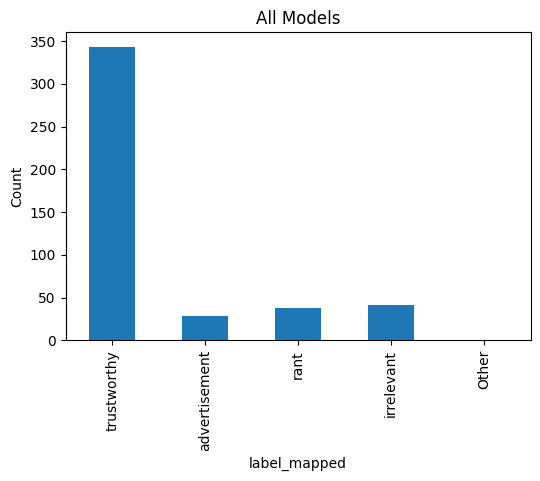

label_mapped
trustworthy      343
advertisement     28
rant              38
irrelevant        41
Other              0
Name: count, dtype: int64

Label Distribution (BART):


/tmp/ipython-input-3525229743.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_mapped'] = df['label'].apply(lambda x: x if x in candidate_labels else "Other")


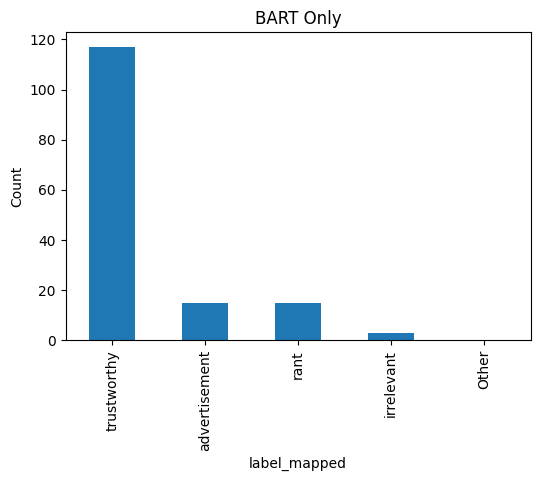

label_mapped
trustworthy      117
advertisement     15
rant              15
irrelevant         3
Other              0
Name: count, dtype: int64

Label Distribution (T5):


/tmp/ipython-input-3525229743.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_mapped'] = df['label'].apply(lambda x: x if x in candidate_labels else "Other")


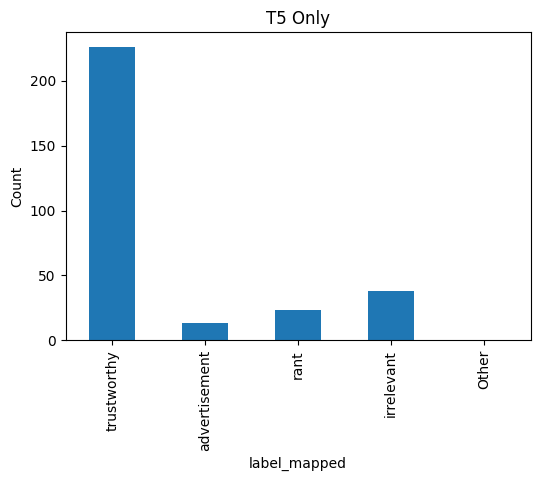

label_mapped
trustworthy      226
advertisement     13
rant              23
irrelevant        38
Other              0
Name: count, dtype: int64


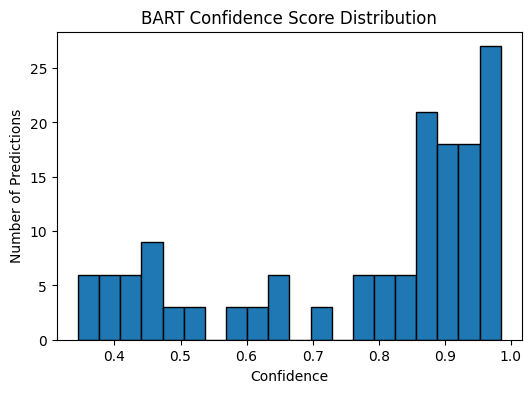

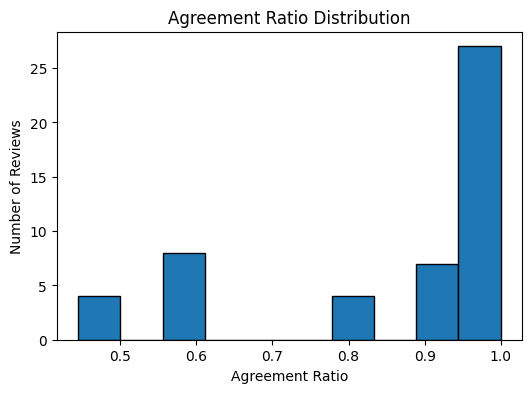


Reviews with low agreement (<0.5): 4
                                                                                       review most_common_label  agreement_ratio                                                                                                                 all_labels
22                                 It is not p/p. Doner came cold and that's why it was hard.              rant         0.444444                                    [rant, rant, rant, irrelevant, irrelevant, advertisement, rant, irrelevant, irrelevant]
28                                                                       Place was not clear.     advertisement         0.444444  [advertisement, advertisement, advertisement, trustworthy, irrelevant, advertisement, irrelevant, irrelevant, irrelevant]
40  The taste of hamburgers is not as good as exaggerated. It's also an expensive restaurant.     advertisement         0.444444            [advertisement, advertisement, advertisement, trustworthy, trustwo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random
import seaborn as sns

pd.set_option("display.max_rows", None)       # show all rows
pd.set_option("display.max_columns", None)    # show all columns
pd.set_option("display.width", 1000)          # widen display so it doesn’t wrap weirdly
pd.set_option("display.max_colwidth", None)   # don’t truncate column text (important for all_labels)

# -----------------------------
# 1️⃣ Load stress test results
# -----------------------------
stress_df = pd.read_csv("stress_test_results.csv")
stress_df['label'] = stress_df['label'].str.lower().str.strip()

candidate_labels = ["trustworthy", "advertisement", "rant", "irrelevant"]

# -----------------------------
# 2️⃣ Unexpected labels
# -----------------------------
extra_labels_all = set(stress_df['label'].unique()) - set(candidate_labels)
extra_labels_bart = set(stress_df.loc[stress_df['model']=="bart", 'label'].unique()) - set(candidate_labels)
extra_labels_t5 = set(stress_df.loc[stress_df['model'].str.contains("t5"), 'label'].unique()) - set(candidate_labels)

print("Unexpected labels (All):", extra_labels_all)
print("Unexpected labels (BART):", extra_labels_bart)
print("Unexpected labels (T5):", extra_labels_t5)

# -----------------------------
# 3️⃣ Label distribution
# -----------------------------
def plot_label_distribution(df, title):
    # Map unexpected labels into "Other"
    df['label_mapped'] = df['label'].apply(lambda x: x if x in candidate_labels else "Other")

    label_counts = df['label_mapped'].value_counts()
    label_counts = label_counts.reindex(candidate_labels + ["Other"], fill_value=0)

    plt.figure(figsize=(6,4))
    label_counts.plot(kind='bar')
    plt.title(title)
    plt.ylabel("Count")
    plt.show()

    return label_counts

print("\nLabel Distribution (All Models):")
print(plot_label_distribution(stress_df, "All Models"))

print("\nLabel Distribution (BART):")
print(plot_label_distribution(stress_df[stress_df['model']=="bart"], "BART Only"))

print("\nLabel Distribution (T5):")
print(plot_label_distribution(stress_df[stress_df['model'].str.contains("t5")], "T5 Only"))

# -----------------------------
# 4️⃣ Confidence histogram (BART only)
# -----------------------------
if "confidence" in stress_df.columns:
    bart_conf = stress_df.loc[stress_df['model']=="bart", "confidence"].dropna()
    plt.figure(figsize=(6,4))
    plt.hist(bart_conf, bins=20, edgecolor="black")
    plt.title("BART Confidence Score Distribution")
    plt.xlabel("Confidence")
    plt.ylabel("Number of Predictions")
    plt.show()

# -----------------------------
# 5️⃣ Agreement ratio
# -----------------------------
def compute_agreement(df):
    agreements = []
    for review, group in df.groupby("review"):
        labels = [str(l).lower().strip() for l in group["label"]]
        most_common_label, count = Counter(labels).most_common(1)[0]
        agreement_ratio = count / len(labels)
        agreements.append({
            "review": review,
            "most_common_label": most_common_label,
            "agreement_ratio": agreement_ratio,
            "all_labels": labels
        })
    return pd.DataFrame(agreements)

agreement_df = compute_agreement(stress_df)

# Show histogram
plt.figure(figsize=(6,4))
plt.hist(agreement_df['agreement_ratio'], bins=10, edgecolor="black")
plt.xlabel("Agreement Ratio")
plt.ylabel("Number of Reviews")
plt.title("Agreement Ratio Distribution")
plt.show()

# Low agreement
low_agreement = agreement_df[agreement_df['agreement_ratio'] < 0.5]
print(f"\nReviews with low agreement (<0.5): {len(low_agreement)}")
print(low_agreement.head())

# -----------------------------
# 6️⃣ Random sample of 20
# -----------------------------
print("\nRandom sample of 20 reviews with labels:")
print(stress_df.sample(20, random_state=random.randint(0,1000)))



In [ ]:
import pandas as pd
import random

# Assuming your DataFrame is named 'stress_df'
# Filter for only BART model predictions
bart_df = stress_df[stress_df['model'] == 'bart']

candidate_labels = ["trustworthy", "advertisement", "rant", "irrelevant"]
random_state = 42
sample_size = 10

# Loop through each candidate label
for label in candidate_labels:
    # Filter the DataFrame for the current label
    filtered_df = bart_df[bart_df['label_mapped'] == label]

    # Check if there are enough reviews to sample
    if len(filtered_df) > 0:
        sample = filtered_df.sample(n=min(sample_size, len(filtered_df)), random_state=random_state)

        print(f"\n--- Random Sample of {len(sample)} '{label}' Reviews from BART ---")
        for index, row in sample.iterrows():
            print(f"Review (Index {index}): {row['review']}")
            print("-" * 30)
    else:
        print(f"\n--- No '{label}' reviews found for BART model. ---")


--- Random Sample of 10 'trustworthy' Reviews from BART ---
Review (Index 173): Even though it was overcrowded; our orders came very quickly. Except for the künefe; all the treats were delicious. The künefe tasted oily. I recommend you to go to a very clean and relevant place.
------------------------------
Review (Index 19): The place is beautiful and clean. The employees were very kind and concerned. I ate rice and also had sautéed chicken. The flavor was good except the chicken sauté was greasy.
------------------------------
Review (Index 200): Really good, great place for dinner with family or happy hours with friends.

Food was delicious, the sirloin was a bit expensive but worth the price.

The service was outstanding, simply amazing, staff were very helpful and they were very careful in regard to food allergy and cross contamination.

Not a big deal but if the igloos were facing to the river (same as in Coppa Club Putney) the atmosphere would improve by 300%, I wouldn’t mind p

In [ ]:
import pandas as pd
import random
import re
from collections import Counter

# Assuming your DataFrame is named 'stress_df'
# and the normalize_label function is already defined as in previous prompts.
# For demonstration, I will include a basic version here.
def normalize_label(label):
    label = str(label).lower().strip()
    mapping = {
        "trustworthy": "trustworthy",
        "trustful": "trustworthy",
        "advertisement": "advertisement",
        "ad": "advertisement",
        "rant": "rant",
        "irrelevant": "irrelevant",
        "untrustworthy": "rant",
        "unsatisfactory": "rant",
        "inappropriate": "rant",
        "expensive": "irrelevant",
        "good": "trustworthy",
        "excellent": "trustworthy"
    }
    for k, v in mapping.items():
        if k in label:
            return v

    return "irrelevant" # Fallback

# Apply normalization to create a new column
stress_df['normalized_label'] = stress_df['label'].apply(normalize_label)

# Filter for T5 model predictions (base and large)
t5_df = stress_df[stress_df['model'].str.contains("t5")]

candidate_labels = ["trustworthy", "advertisement", "rant", "irrelevant"]
random_state = 42
sample_size = 10

# Loop through each candidate label
for label in candidate_labels:
    # Filter the DataFrame for the current normalized label
    filtered_df = t5_df[t5_df['normalized_label'] == label]

    # Check if there are enough reviews to sample
    if len(filtered_df) > 0:
        sample = filtered_df.sample(n=min(sample_size, len(filtered_df)), random_state=random_state)

        print(f"\n--- Random Sample of {len(sample)} '{label}' Reviews from T5 Models ---")
        for index, row in sample.iterrows():
            print(f"Original Label: {row['label']}")
            print(f"Review (Index {index}): {row['review']}")
            print("-" * 30)
    else:
        print(f"\n--- No '{label}' reviews found for T5 models. ---")


--- Random Sample of 10 'trustworthy' Reviews from T5 Models ---
Original Label: trustworthy
Review (Index 15): A restaurant with a beautiful view. It was nice to have breakfast with this view. The only problem was that the place was a little dirty.
------------------------------
Original Label: trustworthy
Review (Index 354): The flavor that I ate as a child is here; but there were many queues; as in all parts of Istanbul.
------------------------------
Original Label: trustworthy
Review (Index 220): A great starbucks branch located in Bodrum center / bazaar / port. It's great because the layout; the environment; the place and the service are very successful.
------------------------------
Original Label: trustworthy
Review (Index 401): We went here for my birthday last week and we loved it. The food was fantastic and from the moment you walk through the door you are made welcome. I think they may have been short staffed this day but this did not impact our experience.

From start to

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co


Logistic Regression - Best params: {'clf__C': 1.0, 'clf__penalty': 'l1'}
Logistic Regression - Best CV f1_macro: 0.4844

=== Logistic Regression ===
Accuracy:     0.8590
F1 (macro):   0.4844
Precision(m): 0.4386
Recall(m):    0.5823

Classification Report:
               precision    recall  f1-score   support

advertisement     0.3636    0.6667    0.4706         6
   irrelevant     0.0000    0.0000    0.0000         2
         rant     0.4151    0.7857    0.5432        28
  trustworthy     0.9758    0.8768    0.9237       276

     accuracy                         0.8590       312
    macro avg     0.4386    0.5823    0.4844       312
 weighted avg     0.9075    0.8590    0.8749       312



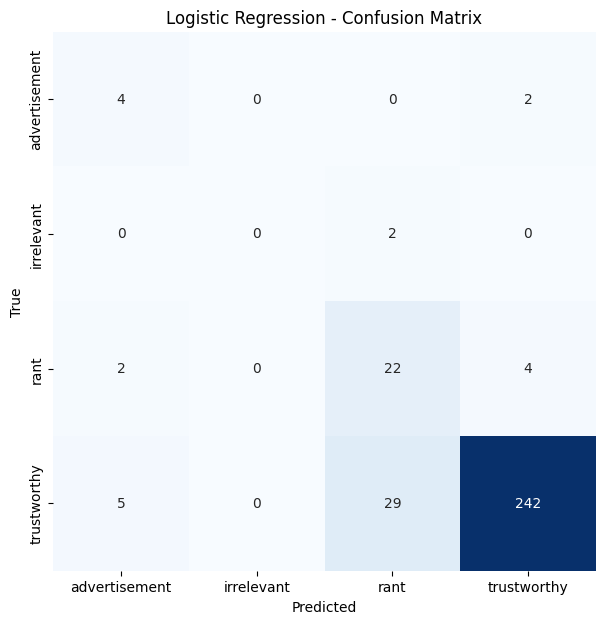

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Random Forest - Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 5}
Random Forest - Best CV f1_macro: 0.3513

=== Random Forest ===
Accuracy:     0.8846
F1 (macro):   0.3642
Precision(m): 0.3482
Recall(m):    0.3864

Classification Report:
               precision    recall  f1-score   support

advertisement     0.0000    0.0000    0.0000         6
   irrelevant     0.0000    0.0000    0.0000         2
         rant     0.4474    0.6071    0.5152        28
  trustworthy     0.9453    0.9384    0.9418       276

     accuracy                         0.8846       312
    macro avg     0.3482    0.3864    0.3642       312
 weighted avg     0.8763    0.8846    0.8794       312



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


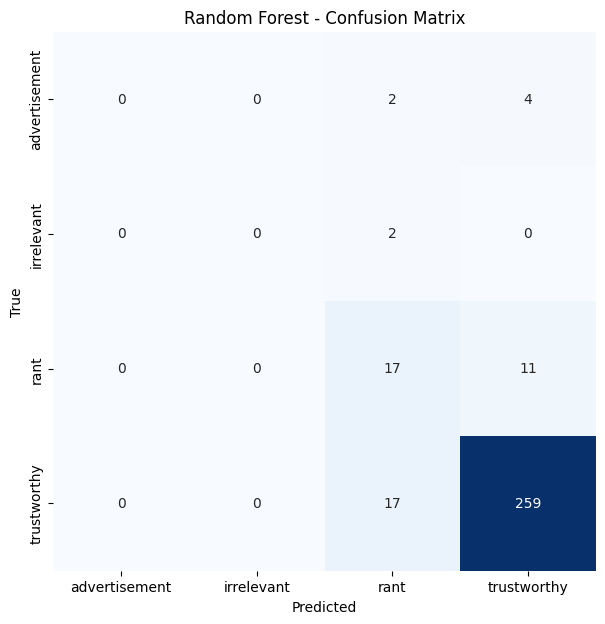

Fitting 5 folds for each of 1 candidates, totalling 5 fits

XGBoost - Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__n_estimators': 400}
XGBoost - Best CV f1_macro: 0.4032

=== XGBoost ===
Accuracy:     0.9038
F1 (macro):   0.4207
Precision(m): 0.4507
Recall(m):    0.4005

Classification Report:
               precision    recall  f1-score   support

advertisement     0.2500    0.1667    0.2000         6
   irrelevant     0.0000    0.0000    0.0000         2
         rant     0.6190    0.4643    0.5306        28
  trustworthy     0.9338    0.9710    0.9520       276

     accuracy                         0.9038       312
    macro avg     0.4507    0.4005    0.4207       312
 weighted avg     0.8864    0.9038    0.8937       312



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


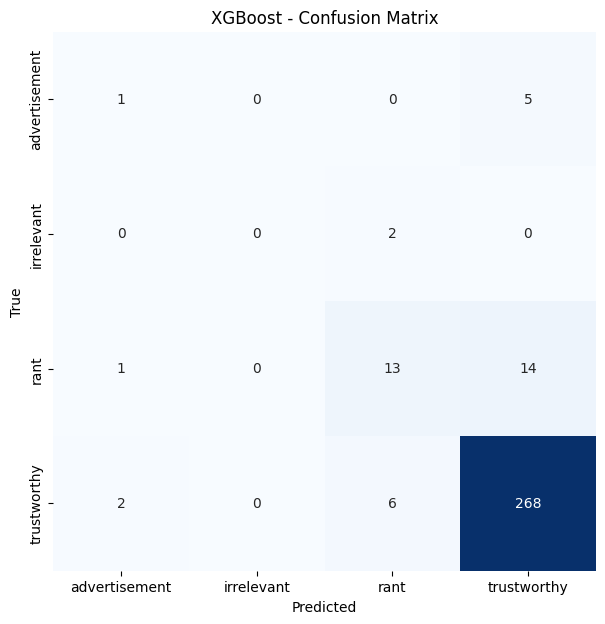


=== Model Comparison (Test Set) ===
                 model  accuracy  f1_macro
0  Logistic Regression  0.858974  0.484366
2              XGBoost  0.903846  0.420664
1        Random Forest  0.884615  0.364242


In [ ]:
# ============================================
# 1) DATA INGESTION
# ============================================
import ast
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/pseudo_labels.csv")

# ============================================
# 2) ENCODING & PREPROCESSING
# ============================================

def parse_all_labels(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list):
                return val
            return [s.strip() for s in x.split(",") if s.strip()]
        except Exception:
            return [s.strip() for s in x.split(",") if s.strip()]
    return []

def label_entropy(labels):
    if not labels:
        return 0.0
    vals, counts = np.unique(labels, return_counts=True)
    p = counts / counts.sum()
    return float(-(p * np.log(p + 1e-12)).sum())

def majority_count(labels):
    if not labels:
        return 0
    vals, counts = np.unique(labels, return_counts=True)
    return int(counts.max())

# Parse and engineer features
labels_parsed = df["all_labels"].apply(parse_all_labels)
df["label_list_len"]   = labels_parsed.apply(len)
df["label_entropy"]    = labels_parsed.apply(label_entropy)
df["label_majority_n"] = labels_parsed.apply(majority_count)
df["agreement_ratio"]  = pd.to_numeric(df["agreement_ratio"], errors="coerce").fillna(0.0)

# Clean review + target
df["review"] = df["review"].astype(str).fillna("")
df = df[df["review"].str.strip().ne("")].copy()
y = df["most_common_label"].astype(str).fillna("unknown")

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
classes = label_encoder.classes_
idx_to_class = {i: cls for i, cls in enumerate(classes)}

# Train/test split ONCE
text_col = "review"
numeric_cols = ["agreement_ratio", "label_list_len", "label_entropy", "label_majority_n"]

X_train, X_test, y_train, y_test = train_test_split(
    df[[text_col] + numeric_cols],
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Preprocessor
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1, 2), min_df=2, max_df=0.9)
preprocessor = ColumnTransformer(
    transformers=[
        ("text", tfidf, text_col),
        ("num", StandardScaler(with_mean=False), numeric_cols),
    ]
)

# ============================================
# 3) MODEL SETUP
# ============================================
logreg = LogisticRegression(
    max_iter=2000, n_jobs=-1, class_weight=class_weight_dict,
    solver="saga", multi_class="auto"
)
logreg_grid = {"clf__C": [0.2, 0.5, 1.0], "clf__penalty": ["l2", "l1"]}

rf = RandomForestClassifier(
    n_estimators=500, n_jobs=-1,
    class_weight=class_weight_dict, random_state=42
)
rf_grid = {"clf__max_depth": [20], "clf__min_samples_split": [5]}

xgb = XGBClassifier(
    objective="multi:softprob", num_class=len(classes),
    n_estimators=400, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.9, tree_method="hist",
    eval_metric="mlogloss", random_state=42
)
xgb_grid = {"clf__n_estimators": [400], "clf__max_depth": [8], "clf__learning_rate": [0.1]}

# ============================================
# 4) TRAINING + EVALUATION
# ============================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(clf, X_te, y_te, model_name: str):
    preds = clf.predict(X_te)

    # Decode labels for reporting
    preds_labels = [idx_to_class[p] for p in preds]
    y_labels = [idx_to_class[t] for t in y_te]

    acc = accuracy_score(y_te, preds)
    f1_macro = f1_score(y_te, preds, average="macro")
    prec_macro = precision_score(y_te, preds, average="macro", zero_division=0)
    rec_macro = recall_score(y_te, preds, average="macro", zero_division=0)

    print(f"\n=== {model_name} ===")
    print(f"Accuracy:     {acc:.4f}")
    print(f"F1 (macro):   {f1_macro:.4f}")
    print(f"Precision(m): {prec_macro:.4f}")
    print(f"Recall(m):    {rec_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_labels, preds_labels, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_labels, preds_labels, labels=classes)
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def tune_and_eval(name, base_estimator, param_grid):
    pipe = Pipeline([("prep", preprocessor), ("clf", base_estimator)])
    grid = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    print(f"\n{name} - Best params: {grid.best_params_}")
    print(f"{name} - Best CV f1_macro: {grid.best_score_:.4f}")

    best_model = grid.best_estimator_
    evaluate_model(best_model, X_test, y_test, name)
    return best_model

# Run models
best_logreg = tune_and_eval("Logistic Regression", logreg, logreg_grid)
best_rf     = tune_and_eval("Random Forest", rf, rf_grid)
best_xgb    = tune_and_eval("XGBoost", xgb, xgb_grid)

# Comparison
def quick_compare(models: dict):
    rows = []
    for name, m in models.items():
        preds = m.predict(X_test)
        acc = accuracy_score(y_test, preds)
        f1m = f1_score(y_test, preds, average="macro")
        rows.append({"model": name, "accuracy": acc, "f1_macro": f1m})
    comp = pd.DataFrame(rows).sort_values("f1_macro", ascending=False)
    print("\n=== Model Comparison (Test Set) ===")
    print(comp)
    return comp

comparison_df = quick_compare({
    "Logistic Regression": best_logreg,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
})


In [ ]:
# Save individual models
import joblib

joblib.dump(best_logreg, "best_logreg.pkl")
joblib.dump(best_rf, "best_rf.pkl")
joblib.dump(best_xgb, "best_xgb.pkl")

['best_xgb.pkl']

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from collections import Counter

# Dictionary of models you want to ensemble
models = {
    "LogReg": best_logreg,
    "RandomForest": best_rf,
    "XGBoost": best_xgb
}

def predict_review(review_text):
    # Wrap into dataframe with placeholder numeric features
    data = pd.DataFrame([{
        "review": review_text,
        "agreement_ratio": 0.0,
        "label_list_len": 1,
        "label_entropy": 0.0,
        "label_majority_n": 1
    }])

    # Collect predictions from all models
    preds = {}
    for name, model in models.items():
        pred_idx = model.predict(data)[0]
        preds[name] = idx_to_class[pred_idx]

    # Majority vote
    votes = list(preds.values())
    majority = Counter(votes).most_common(1)[0][0]

    return preds, majority

# --- Widgets ---
text_input = widgets.Text(
    value="",
    placeholder="Type a Google review here...",
    description="Review:",
    layout=widgets.Layout(width="80%")
)

output = widgets.Output()

def on_submit(change):
    with output:
        clear_output()
        if change.value.strip():
            preds, majority = predict_review(change.value.strip())
            print("Model predictions:")
            for model_name, label in preds.items():
                print(f"  {model_name}: {label}")
            print(f"\n🗳️ Final Majority Vote: {majority}")
        else:
            print("⚠️ Please enter a review.")

text_input.on_submit(on_submit)

display(text_input, output)



Text(value='', description='Review:', layout=Layout(width='80%'), placeholder='Type a Google review here...')

Output()